# PocMol：本地复合物模型批量计算

本 Notebook 使用 `Structures/` 目录中的复合物结构文件（`*.cif/*.mmcif/*.pdb/*.ent`）进行计算，
并将所有数据与图件输出到带时间戳的目录。


In [1]:
from __future__ import annotations

from pathlib import Path
import os
import subprocess
import sys

# Locate repo root (folder containing `pocmol/`) and switch CWD there,
# so all paths below can stay relative.
repo_root = Path.cwd().resolve()
while repo_root != repo_root.parent and not (repo_root / 'pocmol').exists():
    repo_root = repo_root.parent
assert (repo_root / 'pocmol').exists(), 'Could not locate repo root containing pocmol/'
os.chdir(repo_root)
print('cwd:', Path.cwd().name)

# Make repo root importable (avoid absolute paths).
if '.' not in sys.path:
    sys.path.insert(0, '.')


cwd: PocMol


In [2]:
# 参数配置（按需修改）
from datetime import datetime
RUN_TS = datetime.now().strftime('%Y%m%d_%H%M%S')
OUT_BASE = Path('outputs') / f'structures_runs_{RUN_TS}'
STRUCTURES_DIR = Path('Structures')
CUTOFF = 6.0
MAX_CANDIDATES = 250
MIN_SIM = 0.30
MIN_QED = 0.20
MAX_RO5_VIOLATIONS = 2
USE_PUBCHEM = True
PUBCHEM_THRESHOLD = 80
SEED = 0

print('OUT_BASE:', OUT_BASE.as_posix())


OUT_BASE: outputs/structures_runs_20260114_013840


## 序列比对图（含二级结构注释）

示例：TYSY_KLEP7 vs TYSY_HUMAN 的全局比对。二级结构优先使用 DSSP（mkdssp），
若系统缺少 DSSP，则用 phi/psi 简化判定作回退。图中加入序列 logo（顶部）与
每条序列上方的二级结构轨道，风格接近 ESPript，适合论文配图级别展示。


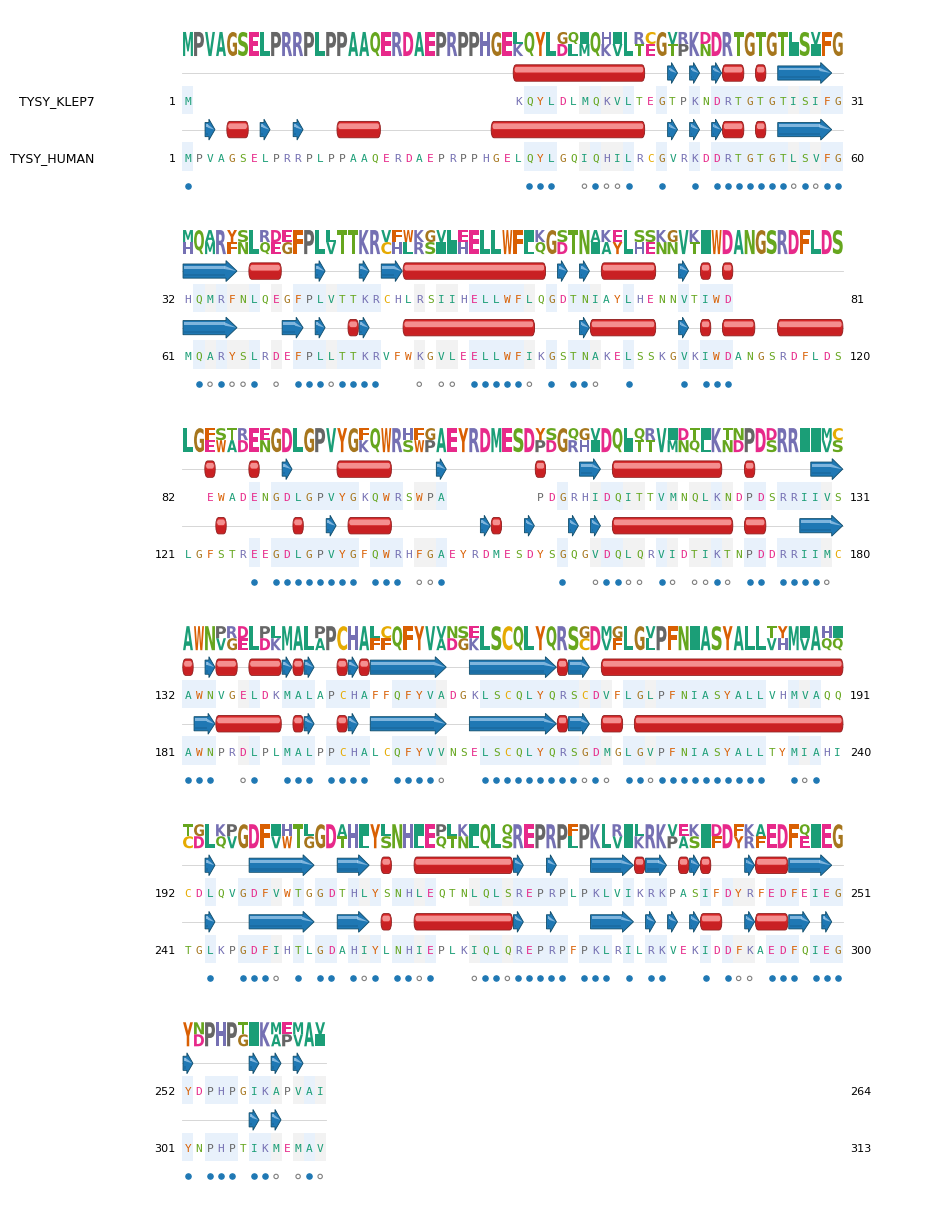

alignment figure: outputs/alignment_tysy_klep7_vs_human.png


In [3]:
import math
import shutil
import subprocess
from collections import Counter
from io import StringIO
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.font_manager import FontProperties
from matplotlib.textpath import TextPath
from matplotlib.transforms import Affine2D

from Bio import Align
from Bio.PDB import PDBParser
from Bio.PDB.DSSP import _make_dssp_dict
from Bio.PDB.Polypeptide import PPBuilder, is_aa
from Bio.SeqUtils import seq1

seq_klep7 = (
    "MKQYLDLMQKVLTEGTPKNDRTGTGTISIFGHQMRFNLQEGFPLVTTKRCHLRSIIHELLWFLQGDTNIAYLHENNVTIWDEWADENGDLGPVYGKQWRSWPAPDGRHIDQITTVMNQLKNDPDSRRIIVSAWNVGELDKMALAPCHAFFQFYVADGKLSCQLYQRSCDVFLGLPFNIASYALLVHMVAQQCDLQVGDFVWTGGDTHLYSNHLEQTNLQLSREPRPLPKLVIKRKPASIFDYRFEDFEIEGYDPHPGIKAPVAI"
)
seq_human = (
    "MPVAGSELPRRPLPPAAQERDAEPRPPHGELQYLGQIQHILRCGVRKDDRTGTGTLSVFGMQARYSLRDEFPLLTTKRVFWKGVLEELLWFIKGSTNAKELSSKGVKIWDANGSRDFLDSLGFSTREEGDLGPVYGFQWRHFGAEYRDMESDYSGQGVDQLQRVIDTIKTNPDDRRIIMCAWNPRDLPLMALPPCHALCQFYVVNSELSCQLYQRSGDMGLGVPFNIASYALLTYMIAHITGLKPGDFIHTLGDAHIYLNHIEPLKIQLQREPRPFPKLRILRKVEKIDDFKAEDFQIEGYNPHPTIKMEMAV"
)

pdb_klep7 = Path("Structures/TYSY_KLEP7_ANX-510.pdb")
pdb_human = Path("Structures/TYSY_HUMAN_ANX-510.pdb")
chain_id = "A"


def align_pairwise(seq_a: str, seq_b: str) -> tuple[str, str]:
    aligner = Align.PairwiseAligner()
    aligner.mode = "global"
    aligner.match_score = 1
    aligner.mismatch_score = -0.5
    aligner.open_gap_score = -10
    aligner.extend_gap_score = -0.5
    alignment = aligner.align(seq_a, seq_b)[0]
    lines = [line for line in alignment.format("fasta").splitlines() if line and not line.startswith(">")]
    return lines[0], lines[1]


def assign_secondary_structure(phi: float | None, psi: float | None) -> str:
    if phi is None or psi is None:
        return "C"
    phi = math.degrees(phi)
    psi = math.degrees(psi)
    if -100 <= phi <= -30 and -80 <= psi <= -5:
        return "H"
    if -170 <= phi <= -90 and 90 <= psi <= 180:
        return "E"
    return "C"


def compute_secondary_structure(pdb_path: Path, chain_id: str = "A") -> tuple[str, str]:
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("struct", str(pdb_path))
    model = structure[0]
    chain = model[chain_id]
    residues = [r for r in chain if is_aa(r, standard=True)]
    pdb_seq = "".join(seq1(r.get_resname()) for r in residues)

    dssp_exec = shutil.which("mkdssp") or shutil.which("dssp")
    if dssp_exec:
        try:
            cmd = [dssp_exec, "--quiet", "--output-format=dssp", str(pdb_path)]
            proc = subprocess.run(cmd, capture_output=True, text=True, check=False)
            out = proc.stdout
            if not out.strip():
                raise RuntimeError(proc.stderr.strip() or "DSSP 未产生输出")
            dssp_dict, _keys = _make_dssp_dict(StringIO(out))

            sec = []
            for res in residues:
                key = (chain_id, res.get_id())
                ss = dssp_dict[key][1] if key in dssp_dict else " "
                if ss in {"H", "G", "I"}:
                    sec.append("H")
                elif ss in {"E", "B"}:
                    sec.append("E")
                else:
                    sec.append("C")
            return pdb_seq, "".join(sec)
        except Exception as exc:
            print(f"DSSP 失败，改用 phi/psi 简化判定: {exc}")

    ppb = PPBuilder()
    sec_by_id = {}
    for pp in ppb.build_peptides(chain):
        for res, (phi, psi) in zip(pp, pp.get_phi_psi_list()):
            sec_by_id[res.get_id()] = assign_secondary_structure(phi, psi)
    sec = [sec_by_id.get(res.get_id(), "C") for res in residues]
    return pdb_seq, "".join(sec)


def map_secondary_to_sequence(pdb_seq: str, pdb_sec: str, target_seq: str) -> str:
    if pdb_seq == target_seq:
        return pdb_sec
    aligned_target, aligned_pdb = align_pairwise(target_seq, pdb_seq)
    out = []
    idx_pdb = 0
    for t_char, p_char in zip(aligned_target, aligned_pdb):
        if t_char == "-":
            if p_char != "-":
                idx_pdb += 1
            continue
        if p_char == "-":
            out.append("C")
        else:
            out.append(pdb_sec[idx_pdb])
            idx_pdb += 1
    return "".join(out)


def build_positions(aligned_seq: str) -> list[int | None]:
    positions = []
    idx = 0
    for ch in aligned_seq:
        if ch == "-":
            positions.append(None)
        else:
            idx += 1
            positions.append(idx)
    return positions


AA_COLORS = {
    **{aa: "#1b9e77" for aa in "AILMV"},
    **{aa: "#d95f02" for aa in "FYW"},
    **{aa: "#7570b3" for aa in "KRH"},
    **{aa: "#e7298a" for aa in "DE"},
    **{aa: "#66a61e" for aa in "STNQ"},
    "C": "#e6ab02",
    "G": "#a6761d",
    "P": "#666666",
}
AA_GROUP = {aa: group for group, letters in {
    "hydrophobic": "AILMV",
    "aromatic": "FYW",
    "positive": "KRH",
    "negative": "DE",
    "polar": "STNQ",
    "special": "CGP",
}.items() for aa in letters}

HELIX_COLOR = "#d62728"
HELIX_EDGE = "#8b1a1a"
HELIX_HIGHLIGHT = "#ffb3b3"
HELIX_SHADOW = "#a50f15"
STRAND_COLOR = "#1f78b4"
STRAND_EDGE = "#0f4c6a"
STRAND_HIGHLIGHT = "#cfe8ff"
STRAND_SHADOW = "#0b3c5d"

LOGO_FONT = FontProperties(family="DejaVu Sans", weight="bold")


def similar(a: str, b: str) -> bool:
    if a == "-" or b == "-":
        return False
    return AA_GROUP.get(a) == AA_GROUP.get(b)


def draw_logo_letter(ax, letter: str, x: float, y_bottom: float, height: float) -> None:
    if height <= 0:
        return
    path = TextPath((0, 0), letter, size=1, prop=LOGO_FONT)
    bounds = path.get_extents()
    if bounds.width == 0 or bounds.height == 0:
        return

    scale_x = 0.9 / bounds.width
    # y 轴是倒置的：这里先做一次 y 方向翻转，抵消 invert_yaxis 的镜像效果
    scale_y = -height / bounds.height

    transform = (
        Affine2D()
        .translate(-bounds.x0, -bounds.y0)
        .scale(scale_x, scale_y)
        .translate(x + 0.05, y_bottom)
    )

    ax.add_patch(
        patches.PathPatch(
            path,
            lw=0,
            fc=AA_COLORS.get(letter, "#000000"),
            transform=transform + ax.transData,
        )
    )


def draw_logo_track(ax, y: float, block_a: str, block_b: str) -> None:
    logo_height = 0.85
    y_bottom = y + 0.95
    for i, (aa, bb) in enumerate(zip(block_a, block_b)):
        letters = [c for c in (aa, bb) if c != "-"]
        if not letters:
            continue
        counts = Counter(letters)
        total = sum(counts.values())
        heights = {letter: logo_height * (count / total) for letter, count in counts.items()}

        y_cursor = y_bottom
        for letter, h in sorted(heights.items(), key=lambda kv: kv[1]):
            draw_logo_letter(ax, letter, i, y_cursor, h)
            y_cursor -= h


def draw_helix_segment(ax, x0: float, x1: float, y: float) -> None:
    w = x1 - x0
    if w <= 0.4:
        return

    y0 = y + 0.28
    h = 0.54

    # 主体（圆柱）
    ax.add_patch(
        patches.FancyBboxPatch(
            (x0 + 0.05, y0),
            w - 0.1,
            h,
            boxstyle="round,pad=0.02,rounding_size=0.27",
            linewidth=0.6,
            edgecolor=HELIX_EDGE,
            facecolor=HELIX_COLOR,
            zorder=2,
        )
    )

    # 底部阴影（增强 3D 圆柱感）
    ax.add_patch(
        patches.FancyBboxPatch(
            (x0 + 0.07, y0 + h * 0.55),
            max(0.0, w - 0.14),
            h * 0.38,
            boxstyle="round,pad=0.02,rounding_size=0.22",
            linewidth=0,
            facecolor=HELIX_SHADOW,
            alpha=0.25,
            zorder=3,
        )
    )

    # 高光（模拟圆柱高光）
    ax.add_patch(
        patches.FancyBboxPatch(
            (x0 + 0.12, y0 + 0.07),
            max(0.0, w - 0.24),
            h * 0.30,
            boxstyle="round,pad=0.02,rounding_size=0.22",
            linewidth=0,
            facecolor=HELIX_HIGHLIGHT,
            alpha=0.75,
            zorder=4,
        )
    )


def draw_strand_segment(ax, x0: float, x1: float, y: float) -> None:
    w = x1 - x0
    if w <= 0.6:
        return

    y0 = y + 0.30
    y1 = y + 0.80
    ymid = y + 0.55

    x0 = x0 + 0.05
    x1 = x1 - 0.05
    w = x1 - x0
    if w <= 0.6:
        return

    head = min(1.0, max(0.55, w * 0.33))
    body_end = x1 - head

    # 主体箭头
    points = [
        (x0, y0),
        (body_end, y0),
        (body_end, y0 - 0.12),
        (x1, ymid),
        (body_end, y1 + 0.12),
        (body_end, y1),
        (x0, y1),
    ]
    ax.add_patch(
        patches.Polygon(
            points,
            closed=True,
            facecolor=STRAND_COLOR,
            edgecolor=STRAND_EDGE,
            linewidth=0.6,
            zorder=2,
        )
    )

    # 上沿高光（更像 ESPript 的立体箭头）
    ax.add_patch(
        patches.Polygon(
            [
                (x0 + 0.10, y0 + 0.06),
                (body_end - 0.10, y0 + 0.06),
                (body_end - 0.10, y0 + 0.16),
                (x0 + 0.10, y0 + 0.16),
            ],
            closed=True,
            facecolor=STRAND_HIGHLIGHT,
            edgecolor="none",
            alpha=0.55,
            zorder=3,
        )
    )
    ax.add_patch(
        patches.Polygon(
            [
                (body_end - 0.12, y0 + 0.06),
                (x1 - 0.06, ymid),
                (body_end - 0.12, y0 + 0.18),
            ],
            closed=True,
            facecolor=STRAND_HIGHLIGHT,
            edgecolor="none",
            alpha=0.55,
            zorder=3,
        )
    )

    # 底部轻微阴影
    ax.add_patch(
        patches.Polygon(
            [
                (x0 + 0.10, y1 - 0.06),
                (body_end - 0.10, y1 - 0.06),
                (body_end - 0.10, y1 - 0.14),
                (x0 + 0.10, y1 - 0.14),
            ],
            closed=True,
            facecolor=STRAND_SHADOW,
            edgecolor="none",
            alpha=0.18,
            zorder=3,
        )
    )


def draw_secondary_track(ax, y: float, sec_block: str) -> None:
    ax.plot([0, len(sec_block)], [y + 0.55, y + 0.55], color="#d0d0d0", lw=0.6, zorder=1)
    i = 0
    while i < len(sec_block):
        code = sec_block[i]
        if code not in {"H", "E"}:
            i += 1
            continue
        j = i
        while j < len(sec_block) and sec_block[j] == code:
            j += 1
        if code == "H":
            draw_helix_segment(ax, i, j, y)
        else:
            draw_strand_segment(ax, i, j, y)
        i = j


def plot_alignment(
    aligned_a: str,
    aligned_b: str,
    sec_a_aligned: str,
    sec_b_aligned: str,
    *,
    labels: tuple[str, str] = ("TYSY_KLEP7", "TYSY_HUMAN"),
    line_width: int = 60,
    out_path: Path | None = None,
) -> None:
    length = len(aligned_a)
    blocks = math.ceil(length / line_width)
    rows_per_block = 6
    block_gap = 1
    total_rows = blocks * (rows_per_block + block_gap) - block_gap
    fig_w = max(8, line_width * 0.18)
    fig_h = max(6, total_rows * 0.38)

    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    ax.set_xlim(-8, line_width + 8)
    ax.set_ylim(total_rows + 0.7, -0.7)
    ax.axis("off")

    pos_a = build_positions(aligned_a)
    pos_b = build_positions(aligned_b)

    for block_idx in range(blocks):
        start = block_idx * line_width
        end = min(length, start + line_width)
        block_a = aligned_a[start:end]
        block_b = aligned_b[start:end]
        block_sec_a = sec_a_aligned[start:end]
        block_sec_b = sec_b_aligned[start:end]
        row_base = block_idx * (rows_per_block + block_gap)
        y_logo = row_base
        y_sec_a = row_base + 1
        y_seq_a = row_base + 2
        y_sec_b = row_base + 3
        y_seq_b = row_base + 4
        y_cons = row_base + 5

        if block_idx == 0:
            ax.text(-8, y_seq_a + 0.55, labels[0], ha="right", va="center", fontsize=9)
            ax.text(-8, y_seq_b + 0.55, labels[1], ha="right", va="center", fontsize=9)

        block_pos_a = [p for p in pos_a[start:end] if p is not None]
        block_pos_b = [p for p in pos_b[start:end] if p is not None]
        if block_pos_a:
            ax.text(-0.6, y_seq_a + 0.55, str(block_pos_a[0]), ha="right", va="center", fontsize=8)
            ax.text(line_width + 0.6, y_seq_a + 0.55, str(block_pos_a[-1]), ha="left", va="center", fontsize=8)
        if block_pos_b:
            ax.text(-0.6, y_seq_b + 0.55, str(block_pos_b[0]), ha="right", va="center", fontsize=8)
            ax.text(line_width + 0.6, y_seq_b + 0.55, str(block_pos_b[-1]), ha="left", va="center", fontsize=8)

        draw_logo_track(ax, y_logo, block_a, block_b)
        draw_secondary_track(ax, y_sec_a, block_sec_a)
        draw_secondary_track(ax, y_sec_b, block_sec_b)

        identity_x = []
        similar_x = []
        for offset, (aa, bb) in enumerate(zip(block_a, block_b)):
            x = offset
            bg = None
            if aa != "-" and bb != "-":
                if aa == bb:
                    bg = "#e8f1fb"
                    identity_x.append(x)
                elif similar(aa, bb):
                    bg = "#f2f2f2"
                    similar_x.append(x)
            if bg:
                ax.add_patch(patches.Rectangle((x, y_seq_a), 1, 1, facecolor=bg, edgecolor="none"))
                ax.add_patch(patches.Rectangle((x, y_seq_b), 1, 1, facecolor=bg, edgecolor="none"))

            if aa != "-":
                ax.text(
                    x + 0.5,
                    y_seq_a + 0.55,
                    aa,
                    ha="center",
                    va="center",
                    fontsize=8,
                    fontfamily="DejaVu Sans Mono",
                    color=AA_COLORS.get(aa, "#000000"),
                )
            if bb != "-":
                ax.text(
                    x + 0.5,
                    y_seq_b + 0.55,
                    bb,
                    ha="center",
                    va="center",
                    fontsize=8,
                    fontfamily="DejaVu Sans Mono",
                    color=AA_COLORS.get(bb, "#000000"),
                )

        if identity_x:
            ax.scatter(
                [x + 0.5 for x in identity_x],
                [y_cons + 0.55] * len(identity_x),
                s=14,
                color="#1f78b4",
                zorder=3,
            )
        if similar_x:
            ax.scatter(
                [x + 0.5 for x in similar_x],
                [y_cons + 0.55] * len(similar_x),
                s=10,
                facecolors="none",
                edgecolors="#7f7f7f",
                linewidths=0.8,
            )

    if out_path:
        out_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(out_path, dpi=400, bbox_inches="tight")
    plt.show()


aligned_klep7, aligned_human = align_pairwise(seq_klep7, seq_human)

seq_klep7_pdb, sec_klep7 = compute_secondary_structure(pdb_klep7, chain_id=chain_id)
seq_human_pdb, sec_human = compute_secondary_structure(pdb_human, chain_id=chain_id)

sec_klep7 = map_secondary_to_sequence(seq_klep7_pdb, sec_klep7, seq_klep7)
sec_human = map_secondary_to_sequence(seq_human_pdb, sec_human, seq_human)


def align_sec_to_aligned(sec: str, aligned_seq: str) -> str:
    out = []
    idx = 0
    for ch in aligned_seq:
        if ch == "-":
            out.append("-")
        else:
            out.append(sec[idx])
            idx += 1
    return "".join(out)


sec_aligned_klep7 = align_sec_to_aligned(sec_klep7, aligned_klep7)
sec_aligned_human = align_sec_to_aligned(sec_human, aligned_human)

alignment_fig = Path("outputs") / "alignment_tysy_klep7_vs_human.png"
plot_alignment(aligned_klep7, aligned_human, sec_aligned_klep7, sec_aligned_human, out_path=alignment_fig)
print("alignment figure:", alignment_fig.as_posix())


In [4]:
# 若 OUT_BASE 下尚无结果，则批量运行（遍历 Structures/ 下的结构文件）
if not (OUT_BASE / 'structures_summary.csv').exists():
    cmd = [
        sys.executable,
        'scripts/run_structures.py',
        '--force',
        '--use-pubchem',
        '--out-base',
        str(OUT_BASE),
        '--structures-dir',
        str(STRUCTURES_DIR),
        '--cutoff',
        str(CUTOFF),
        '--max-candidates',
        str(MAX_CANDIDATES),
        '--min-sim',
        str(MIN_SIM),
        '--min-qed',
        str(MIN_QED),
        '--max-ro5-violations',
        str(MAX_RO5_VIOLATIONS),
        '--pubchem-threshold',
        str(PUBCHEM_THRESHOLD),
    ]
    subprocess.check_call(cmd)
else:
    print('Skip: outputs already exist.')


Skip: outputs already exist.


In [5]:
# 读取汇总表并展示
import pandas as pd
from IPython.display import display
from pathlib import Path

def _resolve_out_base(out_base: Path) -> Path:
    out_base = Path(out_base)
    if (out_base / 'structures_summary.csv').exists():
        return out_base
    candidates = sorted(Path('outputs').glob('structures_runs_*'), key=lambda p: p.stat().st_mtime, reverse=True)
    for cand in candidates:
        if (cand / 'structures_summary.csv').exists():
            print(f"[INFO] OUT_BASE not found, using latest: {cand}")
            return cand
    raise FileNotFoundError("No structures_summary.csv under OUT_BASE or outputs/structures_runs_*")

OUT_BASE = _resolve_out_base(OUT_BASE)

df_structures = pd.read_csv(OUT_BASE / 'structures_summary.csv')
df_common_summary = pd.read_csv(OUT_BASE / 'common_by_ligand_summary.csv')
df_common = pd.read_csv(OUT_BASE / 'common_by_ligand.csv')

print('structures_summary:', df_structures.shape)
print('common_by_ligand_summary:', df_common_summary.shape)
print('common_by_ligand:', df_common.shape)
display(df_structures)
display(df_common_summary)
display(df_common)


structures_summary: (10, 7)
common_by_ligand_summary: (5, 3)
common_by_ligand: (807, 2)


,structure_id,ligand_name,reference_smiles,reference_source,n_generated,status,error
0,"TYSY_HUMAN_10-Propargyl-5,8-Dideazafolic Acid","10-Propargyl-5,8-Dideazafolic Acid",C#CCN(Cc1ccc2nc(N)[nH]c(=O)c2c1)c1ccc(C(=O)N[C...,provided,192,ok,NaN
1,"TYSY_HUMAN_2,4-Diamino-5-phenyl-6-ethylpyrimidine","2,4-Diamino-5-phenyl-6-ethylpyrimidine",CCc1nc(N)nc(N)c1-c1ccccc1,provided,248,ok,NaN
2,"TYSY_HUMAN_6,6-Dimethyl-1-(3-(2,4,5-trichlorop...","6,6-Dimethyl-1-(3-(2,4,5-trichlorophenoxy)prop...",CC1(C)N=C(N)N=C(N)N1OCCCOc1cc(Cl)c(Cl)cc1Cl,provided,168,ok,NaN
3,TYSY_HUMAN_ANX-510,ANX-510,NC1=NC2=NC[C@@H]3CN(c4ccc(C(=O)N[C@H](CCC(=O)O...,derived,199,ok,NaN
4,TYSY_HUMAN_Capecitabine,Capecitabine,CCCCCOC(=O)Nc1nc(=O)n([C@@H]2O[C@H](C)[C@@H](O...,provided,243,ok,NaN
5,"TYSY_KLEP7_10-Propargyl-5,8-Dideazafolic Acid","10-Propargyl-5,8-Dideazafolic Acid",C#CCN(Cc1ccc2nc(N)[nH]c(=O)c2c1)c1ccc(C(=O)N[C...,provided,192,ok,NaN
6,"TYSY_KLEP7_2,4-Diamino-5-phenyl-6-ethylpyrimidine","2,4-Diamino-5-phenyl-6-ethylpyrimidine",CCc1nc(N)nc(N)c1-c1ccccc1,provided,248,ok,NaN
7,"TYSY_KLEP7_6,6-Dimethyl-1-(3-(2,4,5-trichlorop...","6,6-Dimethyl-1-(3-(2,4,5-trichlorophenoxy)prop...",CC1(C)N=C(N)N=C(N)N1OCCCOc1cc(Cl)c(Cl)cc1Cl,provided,168,ok,NaN
8,TYSY_KLEP7_ANX-510,ANX-510,NC1=NC2=NC[C@H]3CN(c4ccc(C(=O)N[C@H](CCC(=O)O)...,derived,199,ok,NaN
9,TYSY_KLEP7_Capecitabine,Capecitabine,CCCCCOC(=O)Nc1nc(=O)n([C@@H]2O[C@H](C)[C@@H](O...,provided,1,ok,NaN


,ligand_name,n_structures,n_common
0,"10-Propargyl-5,8-Dideazafolic Acid",2,192
1,"2,4-Diamino-5-phenyl-6-ethylpyrimidine",2,248
2,"6,6-Dimethyl-1-(3-(2,4,5-trichlorophenoxy)prop...",2,168
3,ANX-510,2,198
4,Capecitabine,2,1


,ligand_name,smiles
0,"10-Propargyl-5,8-Dideazafolic Acid",C#CCN(Cc1cc2c(=O)[nH]c(C)nc2cc1C)c1ccc(C(=O)NC...
1,"10-Propargyl-5,8-Dideazafolic Acid",C#CCN(Cc1cc2c(=O)[nH]c(C)nc2cc1C)c1ccc(C(=O)NC...
2,"10-Propargyl-5,8-Dideazafolic Acid",C#CCN(Cc1cc2c(=O)[nH]c(C)nc2cc1C)c1ccc(C(=O)N[...
3,"10-Propargyl-5,8-Dideazafolic Acid",C#CCN(Cc1cc2c(=O)[nH]c(C)nc2cc1C)c1ccc(C(=O)N[...
4,"10-Propargyl-5,8-Dideazafolic Acid",C#CCN(Cc1cc2c(=O)[nH]c(C)nc2cc1C)c1ccc(C(=O)N[...
...,...,...
802,ANX-510,O=C(O)CCC(NC(=O)c1ccc(CNc2ccc3nc[nH]c(=O)c3c2)...
803,ANX-510,O=C(O)CCC(NC(=O)c1ccc(NCc2ccc3nc[nH]c(=O)c3c2)...
804,ANX-510,O=C(O)CC[C@H](NC(=O)c1ccc(N(CCO)Cc2ccc3nc(CO)[...
805,ANX-510,O=C1NC(=O)C(CC(=O)N2CCN(c3cccc(CNC(=O)c4nc5ccc...
